In [1]:
!pip install contractions

  Using cached contractions-0.1.73-py2.py3-none-any.whl (8.7 kB)
  Using cached textsearch-0.0.24-py2.py3-none-any.whl (7.6 kB)
  Using cached anyascii-0.3.2-py3-none-any.whl (289 kB)
  Using cached pyahocorasick-2.0.0-cp39-cp39-macosx_10_9_x86_64.whl (37 kB)

[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install emoji

  Using cached emoji-2.2.0.tar.gz (240 kB)
  Preparing metadata (setup.py) ... done
  DEPRECATION: emoji is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  Running setup.py install for emoji ... done

[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import glob
import os
import random
import re
import string

import contractions
import emoji
import matplotlib.pyplot as plt 
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfVectorizer,
)
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing import text
from wordcloud import WordCloud

2023-04-20 08:43:31.303786: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dariatoguzova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
path = os.getcwd()
csv_files = glob.glob(os.path.join(path, "data/*.csv"))
dfs = []
for file_ in csv_files:
    dfs.append(df:=pd.read_csv(file_))
    display(df.shape)

display(len(dfs))

(5000, 8)

(2447, 8)

(1764, 8)

(5000, 8)

(2672, 8)

(797, 8)

(749, 8)

(4253, 8)

(1753, 8)

(3215, 8)

(3311, 8)

(3658, 8)

(1921, 8)

(2159, 8)

(1481, 8)

(5000, 8)

(4711, 8)

(1301, 8)

(1195, 8)

(2617, 8)

(1658, 8)

21

In [6]:
df = pd.concat(dfs, ignore_index=True, sort=False)

display(df.shape, df.sample(5))

(56662, 8)

,product_name,rating,title,location_and_date,options,verified_purchase,text,helpful_count
25107,"Kindle Paperwhite (8 GB) – Now with a 6.8"" dis...",4.0,First kindle,Reviewed in the United States 🇺🇸 on December 2...,Option: Without Kindle Unlimited | Digital Sto...,True,First kindle love it so far,NaN
41781,Logitech MK270 Wireless Keyboard And Mouse Com...,4.0,Meh...not the best quality,"Reviewed in the United States on June 29, 2021",Size: 1 Pack,True,Purchased in September 2020 and the space bar ...,NaN
38555,Nintendo Switch Lite - Turquoise,4.0,So far so good,"Reviewed in the United States on September 29,...",Color: Turquoise | Style: Lite Console,True,Purchased this with no previous account. Set u...,NaN
51124,SanDisk 256GB Extreme microSDXC UHS-I Memory C...,5.0,Exactly as described,"Reviewed in the United States on December 26, ...",Capacity: 1TB | Style: Memory Card Only,True,Bought this for my steam deck and it worked gr...,NaN
47391,Acer 21.5 Inch Full HD (1920 x 1080) IPS Ultra...,5.0,Decent Monitor,"Reviewed in the United States 🇺🇸 on March 4, 2021",NaN,True,It’s good for the money,NaN


### Data prep

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56662 entries, 0 to 56661
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   product_name       56662 non-null  object 
 1   rating             56662 non-null  float64
 2   title              56643 non-null  object 
 3   location_and_date  56662 non-null  object 
 4   options            42473 non-null  object 
 5   verified_purchase  56662 non-null  bool   
 6   text               56507 non-null  object 
 7   helpful_count      13455 non-null  object 
dtypes: bool(1), float64(1), object(6)
memory usage: 3.1+ MB


**Drop duplicated rows**

In [8]:
subset = ['product_name', 'rating', 'title', 'text', 'helpful_count']
df[df.duplicated(subset)]

,product_name,rating,title,location_and_date,options,verified_purchase,text,helpful_count
106,Seagate Portable 2TB External Hard Drive HDD —...,5.0,👍,"Reviewed in the United States on March 17, 2023",NaN,True,👍,NaN
1286,Seagate Portable 2TB External Hard Drive HDD —...,5.0,Good,"Reviewed in the United States 🇺🇸 on June 4, 2022",NaN,True,Good,NaN
1408,Seagate Portable 2TB External Hard Drive HDD —...,5.0,Perfect,"Reviewed in the United States on May 19, 2022",NaN,True,Perfect,NaN
2925,Seagate Portable 2TB External Hard Drive HDD —...,5.0,Excelente,"Reviewed in the United States on November 21, ...",NaN,True,Excelente,NaN
3360,Seagate Portable 2TB External Hard Drive HDD —...,5.0,Good,Reviewed in the United States 🇺🇸 on September ...,NaN,True,Good,NaN
...,...,...,...,...,...,...,...,...
54987,"Apple 2021 10.2-inch iPad (Wi-Fi, 64GB) - Spac...",5.0,Great,Reviewed in the United States 🇺🇸 on November 1...,Style: WiFi | Size: 64GB | Color: Space Gray,True,Wow can u say fast shipping and great apple pr...,NaN
56484,SAMSUNG Galaxy Tab A8 10.5” 32GB Android Table...,5.0,Works great!,"Reviewed in the United States on December 26, ...",Color: Dark Gray | Size: 64GB,True,I like how fast it is.,NaN
56504,SAMSUNG Galaxy Tab A8 10.5” 32GB Android Table...,5.0,Ok,"Reviewed in the United States on August 18, 2022",Color: Dark Gray | Size: 32GB,True,Ok,NaN
56596,SAMSUNG Galaxy Tab A8 10.5” 32GB Android Table...,5.0,Excellent,"Reviewed in the United States on September 29,...",Color: Silver | Size: 64GB,True,Excellent,NaN


In [9]:
df = df.drop_duplicates(subset)

df[df.duplicated(subset)]

,product_name,rating,title,location_and_date,options,verified_purchase,text,helpful_count


**Check missing values**

In [10]:
df.isnull().sum()

product_name             0
rating                   0
title                   17
location_and_date        0
options              14054
verified_purchase        0
text                   153
helpful_count        42859
dtype: int64

There are some missed values of `text` column which are should be dropped. `options` column can be dropped. For possible further analysis missed values of `helpful_count` should be replaced with zeros.

In [11]:
df = df.dropna(subset=['text'])

df.isnull().sum()

product_name             0
rating                   0
title                   11
location_and_date        0
options              14016
verified_purchase        0
text                     0
helpful_count        42764
dtype: int64

**Process `helpful_count` column**

1. Extract numeric values.
2. Replace NaN values with 0.
3. Cast into integer.

In [12]:
df['helpful_count'] = df['helpful_count'].str.replace(' people found this helpful', '', regex=False)
df['helpful_count'] = df['helpful_count'].str.replace(',', '', regex=False)
df['helpful_count'] = df['helpful_count'].str.replace('One person found this helpful', '1', regex=False)
df['helpful_count'] = df['helpful_count'].fillna(value=0)
df['helpful_count'] = df['helpful_count'].astype('int')

df.sample(5)

,product_name,rating,title,location_and_date,options,verified_purchase,text,helpful_count
40684,Logitech MK270 Wireless Keyboard And Mouse Com...,5.0,Love logitech,Reviewed in the United States 🇺🇸 on December 6...,Size: 1 Pack,True,perfect basic mouse and keyboard at a great value,1
2838,Seagate Portable 2TB External Hard Drive HDD —...,5.0,Does what’s it’s supposed to.,Reviewed in the United States 🇺🇸 on December 5...,NaN,True,So far so good I haven’t had any problems with...,0
51757,"SAMSUNG Galaxy Tab A7 Lite 8.7"" 32GB WiFi Andr...",1.0,Just get the iPad,Reviewed in the United States 🇺🇸 on December 5...,Style: WiFi Tablet | Color: Gray,True,We wanted a cheap tablet just for travel where...,0
54601,"Apple 2021 10.2-inch iPad (Wi-Fi, 64GB) - Spac...",5.0,Great delivery!,"Reviewed in the United States 🇺🇸 on June 3, 2022",Style: WiFi | Size: 64GB | Color: Silver,True,It came a day after ordering and was delivered...,0
49452,Acer 21.5 Inch Full HD (1920 x 1080) IPS Ultra...,5.0,Fantastic for the price,"Reviewed in the United States on November 27, ...",NaN,False,This is a fantastic monitor for the price. It ...,1


**Handle `location_and_date` column**

1. Split it into `location` and `date` columns (hold location if it has various values).
2. Convert `date` into datetime format.
3. Drop `location_and_date` column.

In [13]:
location_and_date = df['location_and_date'].str.extract(r'Reviewed in ([\w\s]+).+on\s(\w+\s\d{1,2},\s\d{4})')
location = location_and_date[0].str.strip()
location.unique()

array(['the United States'], dtype=object)

As all the reviews are from the US, `location` column can be ommitted.

In [14]:
df['date'] = pd.to_datetime(location_and_date[1], format='%B %d, %Y')

**Drop unneeded columns**

In [15]:
df.drop(['location_and_date', 'options'], axis=1, inplace=True)

In [16]:
df.sample(5)

,product_name,rating,title,verified_purchase,text,helpful_count,date
4240,Seagate Portable 2TB External Hard Drive HDD —...,5.0,Basically as Advertised,True,"Has 1.81 TB, is decently fast, and hasn't fail...",0,2019-12-29
50309,SanDisk 256GB Extreme microSDXC UHS-I Memory C...,5.0,Solid Value,True,Holds a huge number of high def. video and all...,0,2022-10-04
53411,"Apple 2021 10.2-inch iPad (Wi-Fi, 64GB) - Spac...",5.0,Great gift item. The recipient really loves i...,True,Love it! Gave it to my sister for her birthda...,0,2022-07-19
23223,Nintendo Switch – OLED Model w/ Neon Red & Neo...,5.0,Really clean and new,True,I was kinda worried about the quality of the p...,0,2022-06-15
38395,Nintendo Switch Lite - Turquoise,5.0,Great!!!!,False,Great console,1,2019-09-24


**Convert rating from numbers to categories**

In [17]:
df['positivity'] = np.where(df['rating'] > 3, 1, 0)

df.sample(5)

,product_name,rating,title,verified_purchase,text,helpful_count,date,positivity
5581,"EMEET 1080P Webcam with Microphone, C960 Web C...",3.0,Good webcam but has some issues,True,Camera works fine and quality of picture is go...,0,2022-01-11,0
14499,HP 24mh FHD Monitor - Computer Monitor with 23...,5.0,Makes my MS Word docs huge!,True,I recently switched from working on a laptop t...,0,2021-05-26,1
6166,"EMEET 1080P Webcam with Microphone, C960 Web C...",5.0,Online ESL Class,True,Purchased this webcam after reading and watchi...,160,2019-07-21,1
41913,Logitech MK270 Wireless Keyboard And Mouse Com...,5.0,Less wires,True,Works great so far. Been using it for a week. ...,0,2022-01-14,1
49178,Acer 21.5 Inch Full HD (1920 x 1080) IPS Ultra...,1.0,Blinks off and on incessantly,True,forget this monitor,0,2022-06-23,0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56137 entries, 0 to 56661
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   product_name       56137 non-null  object        
 1   rating             56137 non-null  float64       
 2   title              56126 non-null  object        
 3   verified_purchase  56137 non-null  bool          
 4   text               56137 non-null  object        
 5   helpful_count      56137 non-null  int64         
 6   date               56137 non-null  datetime64[ns]
 7   positivity         56137 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 3.5+ MB


In [19]:
df.describe()

,rating,helpful_count,date,positivity
count,56137.000000,56137.000000,56137,56137.000000
mean,4.153856,3.077810,2021-06-14 14:17:37.997399296,0.769207
min,1.000000,0.000000,2017-03-04 00:00:00,0.000000
25%,4.000000,0.000000,2020-07-13 00:00:00,1.000000
50%,5.000000,0.000000,2021-08-15 00:00:00,1.000000
75%,5.000000,0.000000,2022-08-20 00:00:00,1.000000
max,5.000000,7976.000000,2023-04-18 00:00:00,1.000000
std,1.390729,63.364648,NaN,0.421344


In [20]:
df.sample(5)

,product_name,rating,title,verified_purchase,text,helpful_count,date,positivity
42797,Logitech MK270 Wireless Keyboard And Mouse Com...,1.0,Keyboard & mouse,True,They delay is irritating. Drivers up to date. ...,1,2023-02-17,0
42433,Logitech MK270 Wireless Keyboard And Mouse Com...,1.0,Keyboard not responsive,True,"Quite a lot of the time, this keyboard times o...",0,2023-01-24,0
11895,Nintendo USB Switch Pro Controller,5.0,Good price,True,This was a gift and my son has enjoyed it a lot.,0,2019-10-28,1
50864,SanDisk 256GB Extreme microSDXC UHS-I Memory C...,5.0,Five Stars,True,its works with my camera gopro,0,2017-12-04,1
14613,HP 24mh FHD Monitor - Computer Monitor with 23...,4.0,Could be better!,True,All aspects of this monitor from a video view...,0,2021-09-18,1


### Data exploration

In [21]:
sns.set_theme(style='whitegrid')

**Review length distribution**

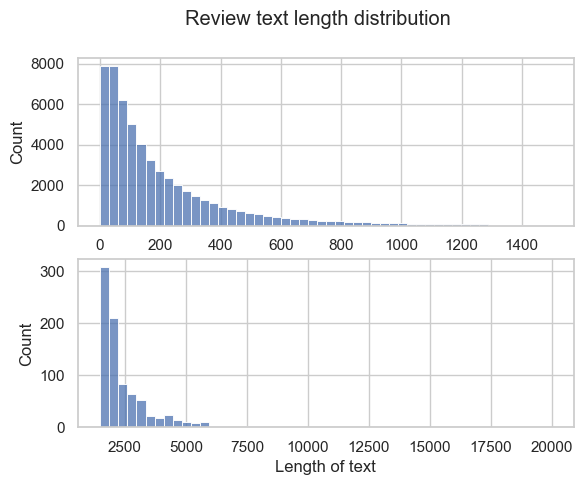

In [22]:
pl_df = pd.DataFrame()
pl_df['text_length'] = df['text'].apply(len)

fig, axs = plt.subplots(nrows=2)
sns.histplot(data=pl_df[pl_df.text_length < 1500],
             x='text_length', bins=50, ax=axs[0])
sns.histplot(data=pl_df[pl_df.text_length >= 1500],
             x='text_length', bins=50, ax=axs[1])
axs[1].set_xlabel('Length of text')
fig.suptitle('Review text length distribution')
plt.show()

**Frequency distribution of n-grams**

In [23]:
def preprocess_review_text(text):
    text = str(text).lower()
    # Expand contractions
    text = contractions.fix(text)
    # Replace emojis with its aliases
    text = emoji.demojize(text)
    # Remove text in square brackets
    text = re.sub('\[.*?\]', '', text)
    # Remove links
    text = re.sub('https?://\S+|www\.\S+', '', text)
    # Remove tags
    text = re.sub('<.*?>+', '', text)
    # Remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    # Remove stop words
    text = ' '.join((
        word for word in text.split() if word not in stopwords.words('english')))    
    return text

In [24]:
kwargs = {
    'preprocessor': preprocess_review_text,
    'ngram_range': (1, 1),
    'dtype': 'int32',
    'strip_accents': 'unicode',
    'decode_error': 'replace',
    'analyzer': 'word',  # Split text into word tokens.
}
vectorizer = CountVectorizer(**kwargs)
vectorized_texts = vectorizer.fit_transform(df['text'])
all_ngrams = list(vectorizer.get_feature_names_out())
num_ngrams = min(50, len(all_ngrams))
all_counts = vectorized_texts.sum(axis=0).tolist()[0]
all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
    zip(all_counts, all_ngrams), reverse=True)])
ngrams = list(all_ngrams)[:num_ngrams]
counts = list(all_counts)[:num_ngrams]

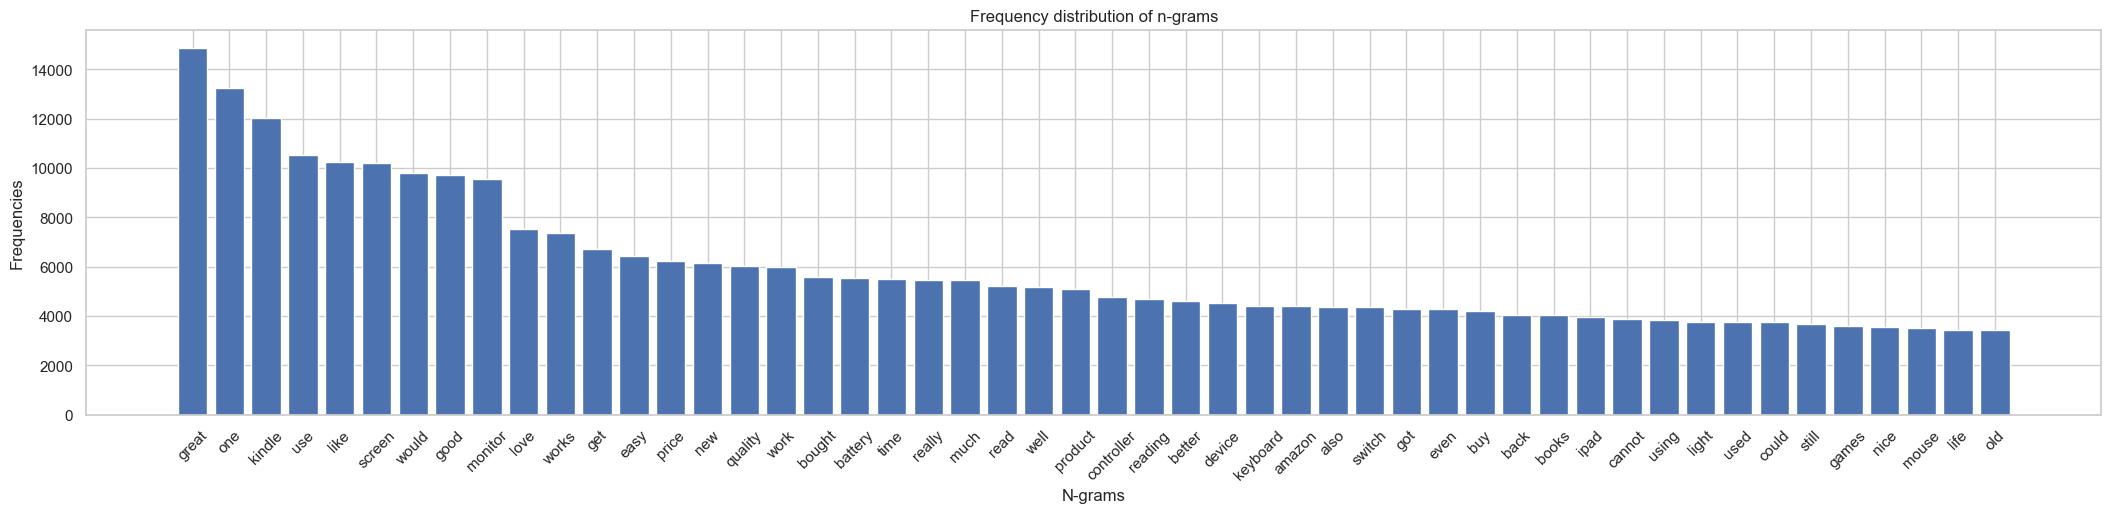

In [25]:
fig, ax = plt.subplots(figsize=(26, 5))
idx = np.arange(num_ngrams)
plt.bar(idx, counts, width=0.8, color='b')
plt.xlabel('N-grams')
plt.ylabel('Frequencies')
plt.title('Frequency distribution of n-grams')
plt.xticks(idx, ngrams, rotation=45)
plt.show()

**Rating distribution**

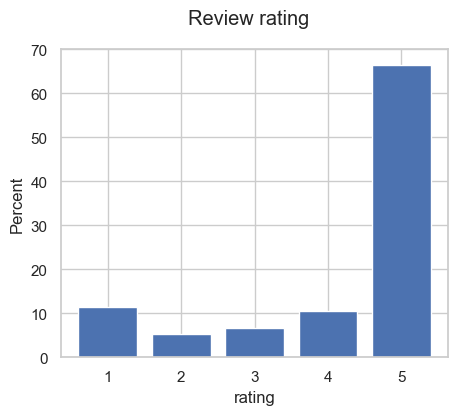

In [26]:
fig, ax = plt.subplots(figsize=(5, 4))
sns.histplot(data=df, x='rating', color='b', alpha=1,
             stat='percent', shrink=.8, discrete=True)
fig.suptitle('Review rating')
plt.ylim(0, 70)
plt.show()

**Visualization of most frequent words with Word Cloud**

In [27]:
def black_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")

def visualize(positivity):
    plt.figure(figsize=(9, 6), facecolor='None')
    vectorizer = TfidfVectorizer(preprocessor=preprocess_review_text, min_df=250)
    X = vectorizer.fit_transform(df[df['positivity'] == positivity]['text'])
    f_df = pd.DataFrame(X.todense().tolist(), columns=vectorizer.get_feature_names_out())
    wordcloud = WordCloud(
        width=900, height=600, max_words=300,
        background_color='white', color_func=black_color_func,
    ).generate_from_frequencies(f_df.T.sum(axis=1))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(
        "Most frequent words in "
        f"{'posititve' if positivity else 'negative and neutral'}"
        " reviews",
        fontsize=14
    )
    plt.show()

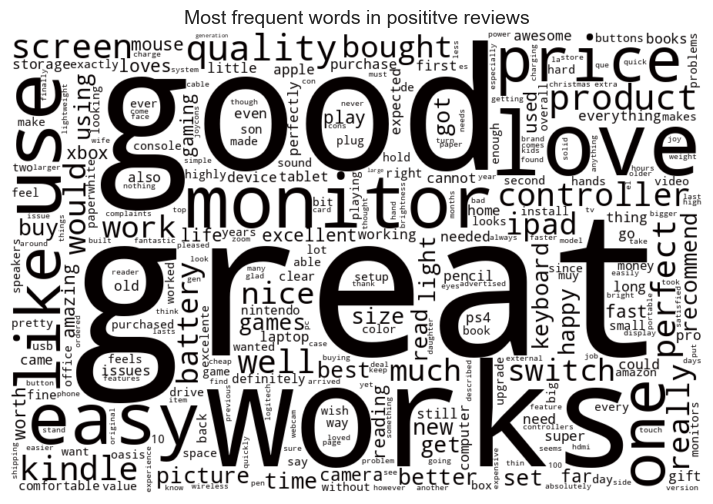

In [28]:
visualize(1)

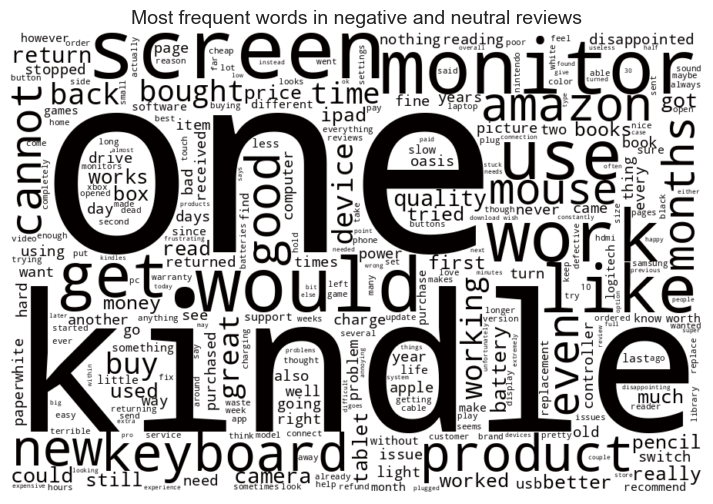

In [29]:
visualize(0)

In [30]:
df = df[['text', 'positivity']]
df.shape

(56137, 2)

### Logistic Regression

**Split data**

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['positivity'], random_state=0)

display(X_train.shape, X_test.shape)

(42102,)

(14035,)

In [32]:
roc_auc_data = {}

**Prepare custom preprocessor**

In [33]:
def preprocess_review_text(text):
    text = str(text).lower()
    # Expand contractions
    text = contractions.fix(text)
    # Replace emojis with its aliases
    text = emoji.demojize(text)
    # Remove text in square brackets
    text = re.sub('\[.*?\]', '', text)
    # Remove links
    text = re.sub('https?://\S+|www\.\S+', '', text)
    # Remove tags
    text = re.sub('<.*?>+', '', text)
    # Remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    return text

**1. CountVectorizer**

In [34]:
vectorizer = CountVectorizer(preprocessor=preprocess_review_text).fit(X_train)
X_train_vectorized = vectorizer.transform(X_train)

len(vectorizer.get_feature_names_out())

25200

In [35]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train_vectorized, y_train)

predictions = model.predict(vectorizer.transform(X_test))

roc_auc = roc_auc_score(y_test, predictions)
roc_auc_data['CountVectorizer'] = roc_auc
print('AUC: %.3f' % roc_auc)

AUC: 0.833


**2. TfidfVectorizer**

In [36]:
NGRAM_RANGE = (1, 2)
TOKEN_MODE = 'word'
MIN_DOCUMENT_FREQUENCY = 5

kwargs = {
    'preprocessor': preprocess_review_text,
    'strip_accents': 'unicode',
    'decode_error': 'replace',
    'analyzer': TOKEN_MODE,
    'min_df': MIN_DOCUMENT_FREQUENCY,
}

vectorizer = TfidfVectorizer(**kwargs)

In [37]:
X_train_vectorized = vectorizer.fit_transform(X_train)

len(vectorizer.get_feature_names_out())

7753

In [38]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train_vectorized, y_train)

predictions = model.predict(vectorizer.transform(X_test))

roc_auc = roc_auc_score(y_test, predictions)
roc_auc_data['TfidfVectorizer'] = roc_auc
print('AUC: %.3f' % roc_auc)

AUC: 0.838


**3. TfidfVectorizer with n-grams**

In [39]:
NGRAM_RANGE = (1, 2)
TOKEN_MODE = 'word'
MIN_DOCUMENT_FREQUENCY = 5

kwargs = {
    'preprocessor': preprocess_review_text,
    'ngram_range': NGRAM_RANGE,
    'strip_accents': 'unicode',
    'decode_error': 'replace',
    'analyzer': TOKEN_MODE,
    'min_df': MIN_DOCUMENT_FREQUENCY,
}

vectorizer = TfidfVectorizer(**kwargs)

In [40]:
X_train_vectorized = vectorizer.fit_transform(X_train)

len(vectorizer.get_feature_names_out())

52333

In [41]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train_vectorized, y_train)

predictions = model.predict(vectorizer.transform(X_test))

roc_auc = roc_auc_score(y_test, predictions)
roc_auc_data['TfidfVectorizer with n-grams'] = roc_auc
print('AUC: %.3f' % roc_auc)

AUC: 0.841


**4. TfidfVectorizer with n-grams and top K features**

In [42]:
X_test_vectorized = vectorizer.transform(X_test)

In [43]:
X_train_vectorized.shape, X_test_vectorized.shape

((42102, 52333), (14035, 52333))

In [44]:
TOP_K = 20000

selector = SelectKBest(f_classif, k=min(TOP_K, X_train_vectorized.shape[1]))
selector.fit(X_train_vectorized, y_train.array)
X_train_vectorized = selector.transform(X_train_vectorized).astype('float32')
X_test_vectorized = selector.transform(X_test_vectorized).astype('float32')

In [45]:
X_train_vectorized.shape, X_test_vectorized.shape

((42102, 20000), (14035, 20000))

In [46]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train_vectorized, y_train)

predictions = model.predict(X_test_vectorized)

roc_auc = roc_auc_score(y_test, predictions)
roc_auc_data['TfidfVectorizer with n-grams and top K features'] = roc_auc
print('AUC: %.3f' % roc_auc)

AUC: 0.838


**Result**

In [47]:
for key, val in roc_auc_data.items():
    print('%.3f -- %s' % (val, key))

0.833 -- CountVectorizer
0.838 -- TfidfVectorizer
0.841 -- TfidfVectorizer with n-grams
0.838 -- TfidfVectorizer with n-grams and top K features


### ML with Keras and Tensorflow

In [48]:
df = df[['text', 'positivity']]
df.shape

(56137, 2)

In [49]:
N_TRAIN = int(0.6 * len(df))
BATCH_SIZE = 512
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [50]:
lr_schedule = optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False
)

In [51]:
train, valid, test = np.split(df.sample(frac=1), [N_TRAIN, int(0.8 * len(df))])

In [52]:
def df_to_dataset(dataframe, shuffle=True):
    df = dataframe.copy()
    labels = df.pop('positivity')
    df = df['text']
    ds = tf.data.Dataset.from_tensor_slices((df, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(BATCH_SIZE)
    ds = ds.cache()
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [53]:
def train_model(model, train_data, valid_data):
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]

    history = model.fit(
        train_data,
        epochs=10,
        callbacks=callbacks,
        validation_data=valid_data,
        verbose=2,
        batch_size=BATCH_SIZE)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
          acc=history['val_acc'][-1], loss=history['val_loss'][-1]))
    return history

In [54]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(valid)
test_data = df_to_dataset(test)

In [55]:
embedding = 'https://tfhub.dev/google/nnlm-en-dim50/2'
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [56]:
hub_layer(list(train_data)[0][0])

2023-04-20 08:54:26.956363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [33682]
	 [[{{node Placeholder/_1}}]]
2023-04-20 08:54:26.956616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [33682]
	 [[{{node Placeholder/_1}}]]
2023-04-20 08:54:27.082814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'sentences' with dtype string and shape [?]
	 [[{{

<tf.Tensor: shape=(512, 50), dtype=float32, numpy=
array([[ 0.41579133, -0.22822294,  0.10677429, ..., -0.14140028,
        -0.15294513,  0.14668763],
       [ 0.01286092, -0.12560846, -0.07347119, ..., -0.3002483 ,
         0.0109719 ,  0.25222474],
       [ 1.023118  ,  0.10533049,  0.29961348, ..., -0.379742  ,
         0.6132398 ,  0.7183382 ],
       ...,
       [ 0.05503729, -0.06428522,  0.0496452 , ...,  0.15759164,
        -0.0912203 ,  0.3630463 ],
       [ 0.38450977, -0.11349504, -0.22421066, ..., -0.11913451,
         0.11305984,  0.29295713],
       [ 0.37353247,  0.10015114, -0.05655481, ..., -0.3234814 ,
         0.3511893 ,  0.2837291 ]], dtype=float32)>

**Basic model**

In [57]:
model = models.Sequential([
    hub_layer,
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=optimizers.Adam(lr_schedule),
              loss='binary_crossentropy',
              metrics=['acc'])

history = train_model(model, train_data, valid_data)

Epoch 1/10


2023-04-20 08:54:27.510644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype string and shape [?]
	 [[{{node Placeholder}}]]
2023-04-20 08:54:27.717460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall' with dtype float and shape [?,50]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall}}]]
2023-04-20 08:54:27.717518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must 

66/66 - 48s - loss: 0.5178 - acc: 0.7606 - val_loss: 0.3952 - val_acc: 0.7908 - 48s/epoch - 729ms/step
Epoch 2/10
66/66 - 46s - loss: 0.3189 - acc: 0.8570 - val_loss: 0.2956 - val_acc: 0.8751 - 46s/epoch - 705ms/step
Epoch 3/10
66/66 - 47s - loss: 0.2236 - acc: 0.9126 - val_loss: 0.2733 - val_acc: 0.8865 - 47s/epoch - 705ms/step
Epoch 4/10
66/66 - 47s - loss: 0.1742 - acc: 0.9362 - val_loss: 0.2801 - val_acc: 0.8858 - 47s/epoch - 706ms/step
Epoch 5/10
66/66 - 48s - loss: 0.1408 - acc: 0.9524 - val_loss: 0.3031 - val_acc: 0.8828 - 48s/epoch - 732ms/step
Validation accuracy: 0.8827825784683228, loss: 0.30309784412384033


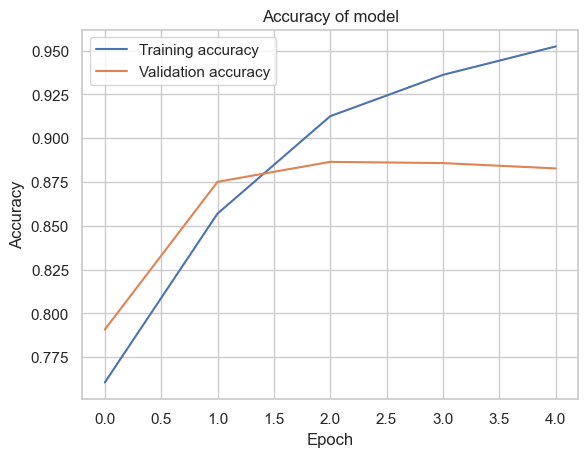

In [58]:
plt.plot(history['acc'], label='Training accuracy')
plt.plot(history['val_acc'], label='Validation accuracy')
plt.title('Accuracy of model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

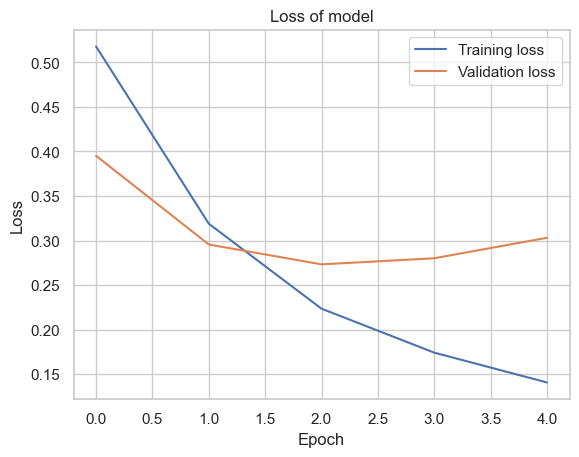

In [59]:
plt.plot(history['loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.title('Loss of model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [60]:
results = model.evaluate(test_data, verbose=2)

for name, value in zip(model.metrics_names, results):
    print("%s: %.3f" % (name, value))

2023-04-20 08:58:23.910965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [11228]
	 [[{{node Placeholder/_1}}]]
2023-04-20 08:58:23.911220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [11228]
	 [[{{node Placeholder/_1}}]]


22/22 - 2s - loss: 0.2894 - acc: 0.8908 - 2s/epoch - 110ms/step
loss: 0.289
acc: 0.891


**Model with dropout**

In [61]:
dropout_model = models.Sequential([
    hub_layer,
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

dropout_model.compile(optimizer=optimizers.Adam(lr_schedule),
                      loss='binary_crossentropy',
                      metrics=['acc'])

history = train_model(dropout_model, train_data, valid_data)

Epoch 1/10


2023-04-20 08:58:26.361508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype string and shape [?]
	 [[{{node Placeholder}}]]


66/66 - 47s - loss: 0.5752 - acc: 0.7740 - val_loss: 0.4295 - val_acc: 0.8735 - 47s/epoch - 709ms/step
Epoch 2/10
66/66 - 46s - loss: 0.3482 - acc: 0.8825 - val_loss: 0.2767 - val_acc: 0.8863 - 46s/epoch - 694ms/step
Epoch 3/10
66/66 - 46s - loss: 0.2311 - acc: 0.9200 - val_loss: 0.2727 - val_acc: 0.8882 - 46s/epoch - 696ms/step
Epoch 4/10
66/66 - 46s - loss: 0.1907 - acc: 0.9354 - val_loss: 0.2938 - val_acc: 0.8860 - 46s/epoch - 697ms/step
Epoch 5/10
66/66 - 46s - loss: 0.1652 - acc: 0.9472 - val_loss: 0.3180 - val_acc: 0.8839 - 46s/epoch - 697ms/step
Validation accuracy: 0.8839405179023743, loss: 0.31803491711616516


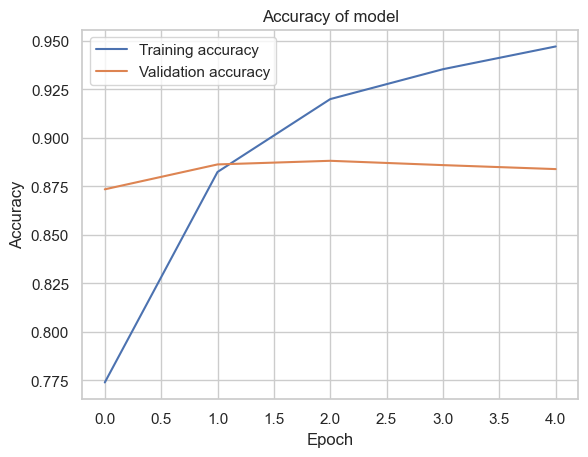

In [62]:
plt.plot(history['acc'], label='Training accuracy')
plt.plot(history['val_acc'], label='Validation accuracy')
plt.title('Accuracy of model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

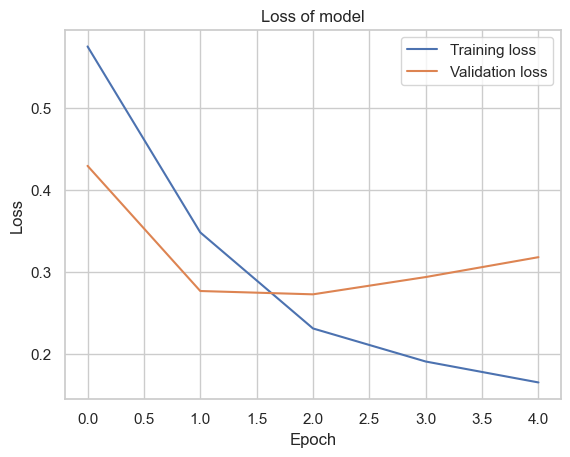

In [63]:
plt.plot(history['loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.title('Loss of model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [64]:
results = dropout_model.evaluate(test_data, verbose=2)

for name, value in zip(dropout_model.metrics_names, results):
    print("%s: %.3f" % (name, value))

22/22 - 2s - loss: 0.3063 - acc: 0.8907 - 2s/epoch - 104ms/step
loss: 0.306
acc: 0.891


**L2 weight regularization**

In [66]:
l2_model = models.Sequential([
    hub_layer,
    layers.Dense(
        16, activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dense(
        16, activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dense(1, activation='sigmoid')
])

l2_model.compile(optimizer=optimizers.Adam(lr_schedule),
                 loss='binary_crossentropy',
                 metrics=['acc'])

history = train_model(l2_model, train_data, valid_data)

Epoch 1/10


2023-04-20 09:03:36.479994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype string and shape [?]
	 [[{{node Placeholder}}]]


66/66 - 50s - loss: 0.5001 - acc: 0.7961 - val_loss: 0.3638 - val_acc: 0.8697 - 50s/epoch - 760ms/step
Epoch 2/10
66/66 - 47s - loss: 0.2408 - acc: 0.9321 - val_loss: 0.3064 - val_acc: 0.8860 - 47s/epoch - 716ms/step
Epoch 3/10
66/66 - 47s - loss: 0.1731 - acc: 0.9557 - val_loss: 0.3227 - val_acc: 0.8847 - 47s/epoch - 716ms/step
Epoch 4/10
66/66 - 47s - loss: 0.1470 - acc: 0.9643 - val_loss: 0.3469 - val_acc: 0.8810 - 47s/epoch - 715ms/step
Validation accuracy: 0.8810011744499207, loss: 0.3469308316707611


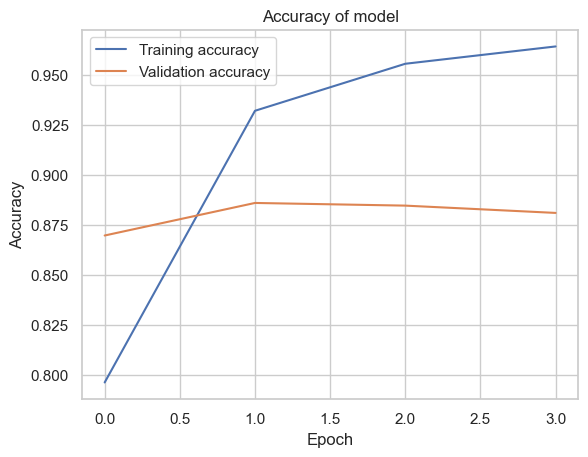

In [67]:
plt.plot(history['acc'], label='Training accuracy')
plt.plot(history['val_acc'], label='Validation accuracy')
plt.title('Accuracy of model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

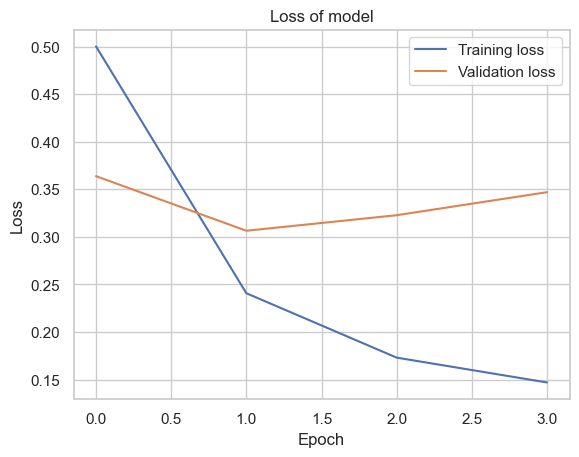

In [68]:
plt.plot(history['loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.title('Loss of model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [69]:
results = l2_model.evaluate(test_data, verbose=2)

for name, value in zip(l2_model.metrics_names, results):
    print("%s: %.3f" % (name, value))

22/22 - 2s - loss: 0.3347 - acc: 0.8880 - 2s/epoch - 110ms/step
loss: 0.335
acc: 0.888


**L2 + dropout**

In [70]:
l2_dropout_model = models.Sequential([
    hub_layer,
    layers.Dense(
        16, activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(
        16, activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

l2_dropout_model.compile(optimizer=optimizers.Adam(lr_schedule),
                         loss='binary_crossentropy',
                         metrics=['acc'])

history = train_model(l2_dropout_model, train_data, valid_data)

Epoch 1/10


2023-04-20 09:06:51.399072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype string and shape [?]
	 [[{{node Placeholder}}]]


66/66 - 49s - loss: 0.5037 - acc: 0.8043 - val_loss: 0.3540 - val_acc: 0.8771 - 49s/epoch - 736ms/step
Epoch 2/10
66/66 - 47s - loss: 0.3195 - acc: 0.8776 - val_loss: 0.3106 - val_acc: 0.8839 - 47s/epoch - 712ms/step
Epoch 3/10
66/66 - 47s - loss: 0.2377 - acc: 0.9206 - val_loss: 0.3355 - val_acc: 0.8841 - 47s/epoch - 712ms/step
Epoch 4/10
66/66 - 47s - loss: 0.1954 - acc: 0.9428 - val_loss: 0.3673 - val_acc: 0.8818 - 47s/epoch - 710ms/step
Validation accuracy: 0.8818027973175049, loss: 0.36731645464897156


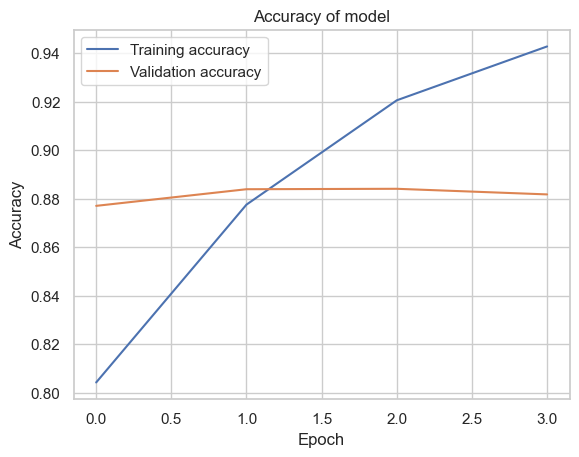

In [71]:
plt.plot(history['acc'], label='Training accuracy')
plt.plot(history['val_acc'], label='Validation accuracy')
plt.title('Accuracy of model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

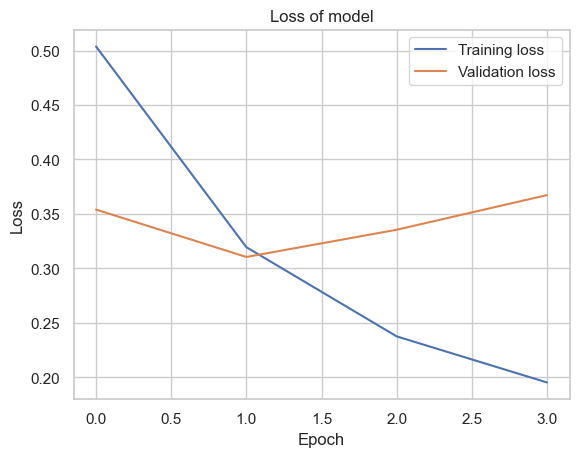

In [72]:
plt.plot(history['loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.title('Loss of model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [73]:
results = dropout_model.evaluate(test_data, verbose=2)

for name, value in zip(dropout_model.metrics_names, results):
    print("%s: %.3f" % (name, value))

22/22 - 2s - loss: 0.3635 - acc: 0.8830 - 2s/epoch - 110ms/step
loss: 0.364
acc: 0.883


### Recurrent Neural Networks & Separable Convolutional Neural Networks

In [74]:
TOP_K = 20000
MAX_SEQUENCE_LENGTH = 500
N_TRAIN = int(0.6 * len(df))
BATCH_SIZE = 512
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [75]:
train, valid, test = np.split(df.sample(frac=1), [N_TRAIN, int(0.8 * len(df))])
X_train, y_train = list(train['text']), np.array(list(train['positivity']))
X_valid, y_valid = list(valid['text']), np.array(list(valid['positivity']))
X_test, y_test = list(test['text']), np.array(list(test['positivity']))

In [76]:
def sequence_vectorize(train_texts, val_texts, test_texts):
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)
    x_test = tokenizer.texts_to_sequences(test_texts)

    # Get max sequence length.
    max_length = len(max(x_train, key=len))
    if max_length > MAX_SEQUENCE_LENGTH:
        max_length = MAX_SEQUENCE_LENGTH

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    x_test = sequence.pad_sequences(x_test, maxlen=max_length)
    return x_train, x_val, x_test, tokenizer.word_index

In [77]:
x_train, x_val, x_test, word_index = sequence_vectorize(X_train, X_valid, X_test)

print(x_train.shape, x_val.shape, x_test.shape, len(word_index))

(33682, 500) (11227, 500) (11228, 500) 24863


In [78]:
num_features = min(len(word_index) + 1, TOP_K)
embedding_dim = 200
input_shape = x_train.shape[1:]
dropout_rate = 0.2
filters = 64
kernel_size = 3
pool_size = 3
learning_rate = 1e-3
epochs=25

**Recurrent Neural Networks**

In [79]:
model = models.Sequential()
model.add(layers.Embedding(input_dim=num_features,
                           output_dim=embedding_dim,
                           input_length=input_shape[0]))
model.add(layers.SpatialDropout1D(dropout_rate))
model.add(layers.LSTM(units=100,
                      dropout=dropout_rate,
                      recurrent_dropout=dropout_rate,
                      return_sequences=False))
model.add(layers.Dense(1, activation='sigmoid'))

In [80]:
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['acc'])

In [81]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]

history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(x_val, y_valid),
    verbose=2,
    batch_size=BATCH_SIZE)

# Print results.
history = history.history
print('Validation accuracy: {acc}, loss: {loss}'.format(
      acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

Epoch 1/25
66/66 - 243s - loss: 0.4226 - acc: 0.8100 - val_loss: 0.2827 - val_acc: 0.8840 - 243s/epoch - 4s/step
Epoch 2/25
66/66 - 243s - loss: 0.2368 - acc: 0.9057 - val_loss: 0.2440 - val_acc: 0.9004 - 243s/epoch - 4s/step
Epoch 3/25
66/66 - 250s - loss: 0.1847 - acc: 0.9285 - val_loss: 0.2393 - val_acc: 0.9044 - 250s/epoch - 4s/step
Epoch 4/25
66/66 - 248s - loss: 0.1553 - acc: 0.9411 - val_loss: 0.2615 - val_acc: 0.9029 - 248s/epoch - 4s/step
Epoch 5/25
66/66 - 246s - loss: 0.1314 - acc: 0.9518 - val_loss: 0.2722 - val_acc: 0.8989 - 246s/epoch - 4s/step
Validation accuracy: 0.8989044427871704, loss: 0.27223217487335205


In [82]:
results = model.evaluate(x_test, y_test, verbose=2)

for name, value in zip(model.metrics_names, results):
    print("%s: %.3f" % (name, value))

351/351 - 25s - loss: 0.2836 - acc: 0.8954 - 25s/epoch - 70ms/step
loss: 0.284
acc: 0.895


**Separable Convolutional Neural Networks**

In [83]:
model = models.Sequential()
model.add(layers.Embedding(input_dim=num_features,
                           output_dim=embedding_dim,
                           input_length=input_shape[0]))
model.add(layers.Dropout(rate=dropout_rate))
model.add(layers.SeparableConv1D(filters=filters,
                                 kernel_size=kernel_size,
                                 activation='relu',
                                 bias_initializer='random_uniform',
                                 depthwise_initializer='random_uniform',
                                 padding='same'))
model.add(layers.SeparableConv1D(filters=filters,
                                 kernel_size=kernel_size,
                                 activation='relu',
                                 bias_initializer='random_uniform',
                                 depthwise_initializer='random_uniform',
                                 padding='same'))
model.add(layers.MaxPooling1D(pool_size=pool_size))
model.add(layers.SeparableConv1D(filters=filters * 2,
                                 kernel_size=kernel_size,
                                 activation='relu',
                                 bias_initializer='random_uniform',
                                 depthwise_initializer='random_uniform',
                                 padding='same'))
model.add(layers.SeparableConv1D(filters=filters * 2,
                                 kernel_size=kernel_size,
                                 activation='relu',
                                 bias_initializer='random_uniform',
                                 depthwise_initializer='random_uniform',
                                 padding='same'))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dropout(rate=dropout_rate))
model.add(layers.Dense(1, activation='sigmoid'))

In [84]:
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['acc'])

In [85]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]

history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(x_val, y_valid),
    verbose=2,
    batch_size=BATCH_SIZE)

# Print results.
history = history.history
print('Validation accuracy: {acc}, loss: {loss}'.format(
      acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

Epoch 1/25
66/66 - 73s - loss: 0.6036 - acc: 0.7715 - val_loss: 0.5506 - val_acc: 0.7639 - 73s/epoch - 1s/step
Epoch 2/25
66/66 - 71s - loss: 0.5382 - acc: 0.7719 - val_loss: 0.5462 - val_acc: 0.7639 - 71s/epoch - 1s/step
Epoch 3/25
66/66 - 72s - loss: 0.5351 - acc: 0.7719 - val_loss: 0.5411 - val_acc: 0.7639 - 72s/epoch - 1s/step
Epoch 4/25
66/66 - 72s - loss: 0.5273 - acc: 0.7704 - val_loss: 0.5296 - val_acc: 0.7599 - 72s/epoch - 1s/step
Epoch 5/25
66/66 - 72s - loss: 0.5090 - acc: 0.7705 - val_loss: 0.4950 - val_acc: 0.7738 - 72s/epoch - 1s/step
Epoch 6/25
66/66 - 71s - loss: 0.4264 - acc: 0.8177 - val_loss: 0.3794 - val_acc: 0.8488 - 71s/epoch - 1s/step
Epoch 7/25
66/66 - 72s - loss: 0.3323 - acc: 0.8747 - val_loss: 0.3395 - val_acc: 0.8698 - 72s/epoch - 1s/step
Epoch 8/25
66/66 - 72s - loss: 0.2834 - acc: 0.8956 - val_loss: 0.3253 - val_acc: 0.8809 - 72s/epoch - 1s/step
Epoch 9/25
66/66 - 72s - loss: 0.2516 - acc: 0.9090 - val_loss: 0.3222 - val_acc: 0.8853 - 72s/epoch - 1s/step
E

In [86]:
results = model.evaluate(x_test, y_test, verbose=2)

for name, value in zip(model.metrics_names, results):
    print("%s: %.3f" % (name, value))

351/351 - 3s - loss: 0.3387 - acc: 0.8906 - 3s/epoch - 10ms/step
loss: 0.339
acc: 0.891
